In [ ]:
        '''
!rm accs.npz
!rm -rf discr*
!rm -rf gener*
!rm -rf checkpoint
!rm *.jpg
!rm *.png
!rm results/*
!rm null
'''

!ls -la

итого 761372
drwxrwxrwx 8 superuser superuser      4096 сен  9 07:14 .
drwxrwxrwx 8 superuser superuser      4096 авг 19 00:10 ..
-rw-rw-r-- 1 superuser superuser   9579326 сен  9 06:57 accs.npz
drwxrwxr-x 4 superuser superuser      4096 сен  5 10:10 Backups
drwxrwxr-x 2 superuser superuser      4096 авг 30 21:51 bu
-rw-rw-r-- 1 superuser superuser        89 сен  9 06:57 checkpoint
-rwxrwxrwx 1 superuser superuser   1233446 мая 19 14:16 CupHoles.ipynb
-rwxrwxrwx 1 superuser superuser     43909 сен  9 07:14 CupHoles_v1.ipynb
-rwxrwxrwx 1 superuser superuser   1638893 июн 16 14:34 CupHoles-V2.ipynb
-rw-rw-r-- 1 superuser superuser      8892 сен  9 06:57 discriminator.tf.data-00000-of-00002
-rw-rw-r-- 1 superuser superuser  11505176 сен  9 06:57 discriminator.tf.data-00001-of-00002
-rw-rw-r-- 1 superuser superuser      4039 сен  9 06:57 discriminator.tf.index
-rw-rw-r-- 1 superuser superuser     16454 сен  9 06:56 generator.tf.data-00000-of-00002
-rw-rw-r-- 1 superuser superuser 749723152

# Задача - __Заполнение "дыр" на изображении (inpainting)__

Предполагается, что НС даны изображение с незаполненными фрагментами, а также маска этих дыр. Решать задачу будем с помощью генеративно-состязательных сетей, т.к. автокодировщик на предварительном исследовании себя показал плохо.

Т.к. сеть будет обучаться не генерации с нуля, а восстанавливать пропущенные фрагменты, то у нас на получаемом изображении будут оригинальные (не сгенерированные) пиксели. Т.о. для дискриминатора на одном изображении будут как примеры настоящих данных, так и сгенерированных. Одна из ключевых идей данной работы - сделать дискриминатор в виде сегментатора, который о каждом пикселе принимает решение - настоящий/поддельный. Это должно сократить время обучения, т.к. на 1 изображении учатся сразу обе НС. Генератор при этом будет как обычно нацелен на максимальный обман дискриминатора.

## Загружаем модули

In [ ]:
#@title # Загрузка модулей, подключение google-drive
try:
    %tensorflow_version 2.x
    
    # Монтирование google-drive
    from google.colab import files, drive
    drive.mount('/mnt/drive', force_remount=True)

    # Задание рабочей папки
    GDfold = "/mnt/drive/My Drive/Colab Notebooks/AIU/Other/01) Cup Holes"
    def drive_path(file=''):
          return GDfold+'/'+file
except:
    def drive_path(file=''):
          return file

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model, layers   # Последовательная модель и слои
from tensorflow.keras import backend as K
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow as tf

import numpy as np                                # Матрицы
from time import time                             # Время
from matplotlib import pyplot as plt              # Графики
#from numba              import jit, njit          # Оптимизация
from tqdm               import tqdm               # Статусбар
from IPython.display    import clear_output       # Очистка вывода ячейки
from scipy.interpolate  import interp1d, griddata # Одно и многомерная интерполяции точек
from skimage            import color              # Смена цветовых пространств
from skimage.morphology import erosion            # Эрозия
from skimage.io         import imread, imsave     # Чтение/запись изображений
from skimage.transform  import resize             # Изменение размера изображения



## Подготавливаем датасет (взят отсюда: https://visualgenome.org/)

In [ ]:
# Качаем, распаковываем
'''
!mkdir images
!wget -c https://cs.stanford.edu/people/rak248/VG_100K_2/images.zip
!wget -c https://cs.stanford.edu/people/rak248/VG_100K_2/images2.zip
!unzip -q images.zip -d images && unzip -q images2.zip -d images && rm *.zip
!ls images
'''

'\n!mkdir images\n!wget -c https://cs.stanford.edu/people/rak248/VG_100K_2/images.zip\n!wget -c https://cs.stanford.edu/people/rak248/VG_100K_2/images2.zip\n!unzip -q images.zip -d images && unzip -q images2.zip -d images && rm *.zip\n!ls images\n'

## Основные параметры данных и сетей

In [ ]:
i = 4 # Размер паддинга
d = 4 # Число паддингов в сетях

# Вычисляемы размер изображений
image_size = [2 * i**d, 3 * i**d]
image_size

[512, 768]

Подбирались параметры для довольно крупного изображения, т.к. предполагается, что генератору гораздо легче будет заполнять дыры, если на изображении полно примеров текстур окружения. Сами маски будут небольшими, но наложено их будет много.

## Генератор изображений

### Генератор масок

С масками пришлось повозиться. Хотелось генерировать какую-то сложную, чтоб генератор был способен к работе с произвольной формой. За основу было взято изображение отсюда: https://im0-tub-ru.yandex.net/i?id=ae20dde39e983dd601c312c031e69f19&n=13

Оно бинаризируется, масштабируется, поворачивается, из него вырезается фрагмент и размещается в произвольном месте маски. И так повторяется несколько раз для одного изображения. Всё это пришлось сделать отдельным классом. Вырезание изображения и т.д. стандартной библиотекой не поддерживается.

Т.к. получаемые 2 класса сильно несбалансированы, генератор производит не только маски, но и веса, пригодные для взвешивания функции потерь.

In [ ]:
masks_parts_num = 3 # Число "кусков" маски на изображении
mask_min_size = (128, 128) # Минимальный размер "куска"

# Генератор маски, реализующий основные трансформации маски
def MaskGen(batch_size):
    mt = ImageDataGenerator(zoom_range=[0.02, 0.05],
                            #preprocessing_function=binary_image,
                            fill_mode='reflect',
                            vertical_flip=True,
                            horizontal_flip=True,
                            rescale=1./255,
                            rotation_range=360,
                            height_shift_range=0.5,
                            width_shift_range=0.5)
    mg = mt.flow_from_directory('masks',
                                class_mode=None,
                                interpolation='bilinear',
                                target_size=(512, 512),
                                color_mode='grayscale',
                                batch_size=1)
    while True:
        yield np.concatenate([next(mg) for _ in range(batch_size)], 0)

    return mg

In [ ]:
#@jit(nopython=False)
def unite_masks(masks_batch, batch_size):
    masks   = np. ones([batch_size] + image_size + [1], np.float32)
    weights = np.zeros([batch_size] + image_size      , np.float32)

    masks_batch_ing = 0
    for ind in range(batch_size):
        for masks_part_ind in range(masks_parts_num):
            if np.random.choice([True, False]):
                masks_part = 1 - masks_batch[masks_batch_ing, :, :, :]
            else:
                masks_part = masks_batch[masks_batch_ing, :, :, :]
            masks_batch_ing += 1

            part_size = np.random.rand(2)
            part_size = [int(part_size[i] ** 5 * (image_size[i] - mask_min_size[i])) + mask_min_size[i] for i in range(2)]
            masks_part = resize(masks_part, part_size)
            masks_part = np.array(masks_part > 0.5, dtype=np.double)

            shift = np.random.rand(2) * 1.4 - 0.2
            shift[shift > 1] = 1
            shift[shift < 0] = 0
            shift = [int((image_size[i] - part_size[i]) * shift[i]) for i in range(2)]
            masks[ind,
                  shift[0] : shift[0] + part_size[0],
                  shift[1] : shift[1] + part_size[1],
                  :] *= masks_part
        weight = masks[ind, :, :, :].copy()
        wmean = weight.mean() # Доля нетронутых пикселей (>>0.5)
        weight[weight == 1] = 1 - wmean # Вес нетронутых пикселей
        weight[weight == 0] =     wmean # Вес восстановленных пикселей
        weights[ind,:,:]  = weight[:,:,0]
    return masks, weights

In [ ]:
# Генератор маски, собирающий несколько масок в одном изображении
def MasksGenerator(masktrans, batch_size):
    masks_list = next(masktrans)
    while True:
        yield unite_masks(masks_list, batch_size)

# Генератор изображений
def ImagesGen(batch_size):
    it = ImageDataGenerator(#zoom_range=[1, 1.1],
                            #fill_mode='reflect',
                            horizontal_flip=True,
                            rescale=1./255)
    
    ig = it.flow_from_directory('images',
                                class_mode=None,
                                interpolation='bicubic',
                                target_size=image_size,
                                batch_size=batch_size)
    return ig


def data_generators(batch_size):

    
    masktrans = MaskGen(batch_size * masks_parts_num)
    
    # Размещение маски в случайном месте изображения (ImageDataGenerator-ом сделать не получается)
    masksgen = MasksGenerator(masktrans, batch_size)
    
    
    imagesgen = ImagesGen(batch_size)
    
    return imagesgen, masksgen

imagesgen, masksgen = data_generators(8)

Found 108249 images belonging to 2 classes.


Примеры изображений

Примеры изображений:


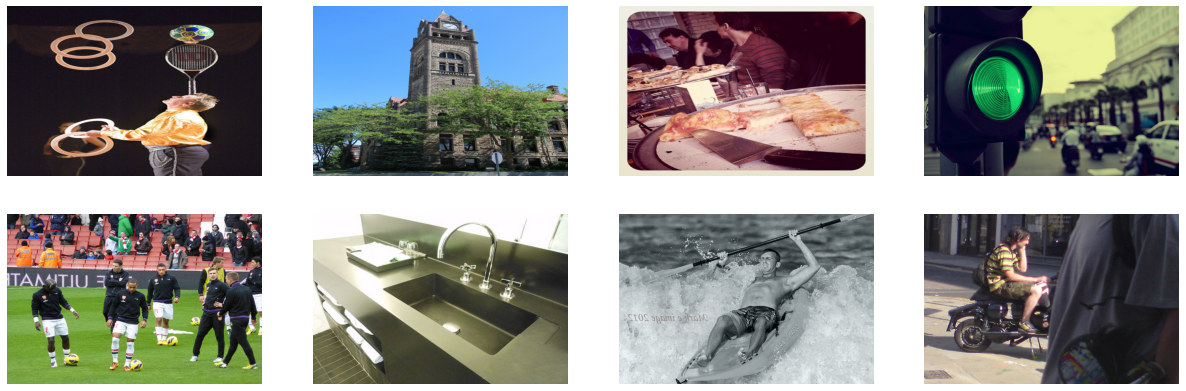

In [ ]:
# Примеры:
print('Примеры изображений:')
plt.figure(figsize=(21,7))
while True:
    try:
        images = next(imagesgen)
        break
    except:
        continue

for ind in range(8):
    if ind>7: break
    plt.subplot(2,4,ind+1)
    plt.imshow(images[ind,:,:,:]);
    plt.axis(False)

Примеры сгенерированных масок:
Found 4 images belonging to 1 classes.


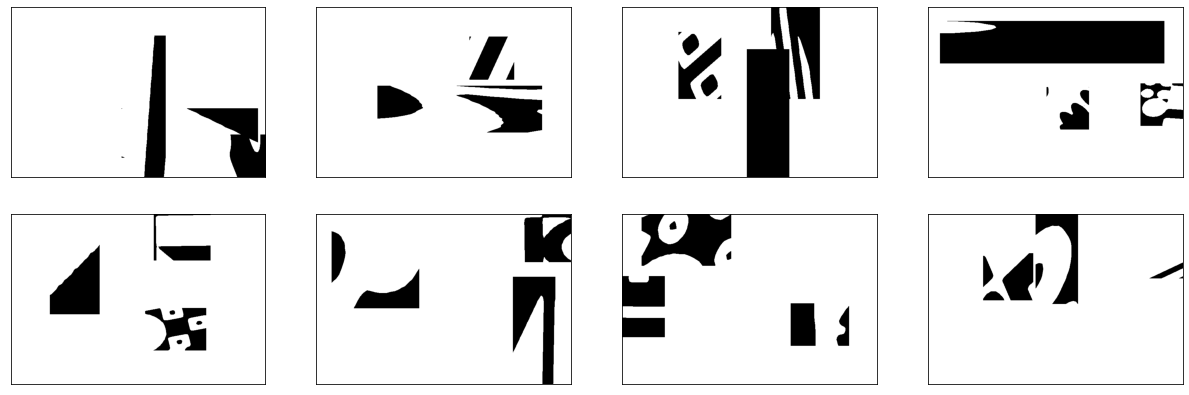

In [ ]:
# Примеры:
print('Примеры сгенерированных масок:')
plt.figure(figsize=(21,7))
masks, weights = next(masksgen)
for ind in range(8):
    if ind>7: break
    fig = plt.subplot(2,4,ind+1)
    plt.imshow(masks[ind,:,:,0], vmin=0, vmax=1, cmap='gray');
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

## Модели сетей

In [ ]:
Conv2D          = layers.Conv2D
Conv2DTranspose = layers.Conv2DTranspose

Генератор и дискриминатор сделаны на базе одной общей Unet модели, взятой произвольно. Однако входы и выходы у сетей разные, поэтому вначале и конце кода стоят условия.

Наложение маски на исходное изображение производится внутри саомого генератора (это чуть проще и вычислительно эффективнее, чем делать это вне гератора), но так, чтобы сама сеть не могла видеть, что скрывается за дырами. Также выход генератора маскируется чтобы изменения были внесены только в пиксели дыр.

In [ ]:
def unet_gen(input_shape = image_size, model_type='generator'):
    min_filt    = 4
    inc_filt    = 2
    pool_size   = 2
    kernel_size = 5
    trans_ker_p = 4 # Увеличение ядра для Conv2DTranspose
    depth       = 5
    use_masks   = True
    activation  = layers.LeakyReLU()
    
    cp = {'kernel_size':kernel_size,
          'padding'    :'same'     ,
          'activation' :activation }
    cpstr = {'kernel_size':kernel_size,
             'padding'    :'same'     ,
             'activation' :activation ,
             'strides'    :pool_size  }
    trcpstr = {'kernel_size':kernel_size + trans_ker_p,
               'padding'    :'same'     ,
               'activation' :activation ,
               'strides'    :pool_size  }
    
    mp = {'filters'    :1             ,
          'kernel_size':3             ,
          'padding'    :'same'        ,
          'activation' :'hard_sigmoid'}

    inp  = layers.Input(shape=input_shape+[3])
    mask = layers.Input(shape=input_shape+[1])
    mask_b = mask
    mask_o = K.stop_gradient(1 - mask)
    if model_type=='generator':
        masked_inp = inp * mask_b
        conv = layers.Concatenate()([masked_inp, mask_b])
    else:
        conv = layers.Concatenate()([       inp, mask_b])
        depth -= 3 # Делаем дискриминатор более локальным для более быстрой сходимости


    filt = inc_filt ** min_filt
    ps   = 1
    conv = Conv2D(filters=filt, **cp, name='inp_conv_' + model_type)(conv)
    conv = layers.BatchNormalization()(conv)
    convs = [conv]
    masks = [mask_b]
    for depth_ind in range(depth):
        filt *= inc_filt
        ps   *= pool_size
        conv = Conv2D(filters=filt, **cpstr)(convs[-1])
        conv = layers.BatchNormalization()(conv)
        if use_masks:
            msk = Conv2D(**mp, strides=ps)(mask_b)
            msk = layers.BatchNormalization()(msk)
            convs.append(layers.Concatenate()([conv, msk]))
        else:
            convs.append(conv)
    
    filt *= inc_filt
    cct = Conv2D(filters=filt, **cpstr)(convs[-1])
    cct = layers.BatchNormalization()(cct)
    for depth_ind in range(depth+1):
        dcon = Conv2DTranspose(filters=filt, **trcpstr)(cct)
        dcon = layers.BatchNormalization()(dcon)
        cct = layers.Concatenate()([dcon,convs.pop()])
        filt = filt // inc_filt
    dcon = Conv2D(filters=filt, **cp)(cct)
    dcon = layers.BatchNormalization()(dcon)
    if use_masks:
        dcon = layers.Concatenate()([dcon,mask_b])
    
    if model_type=='generator':
        out = Conv2D(filters=3, kernel_size=kernel_size,
                     padding='same',
                     activation='sigmoid',
                     name='out_conv_' + model_type)(dcon)
        out = out * mask_o + masked_inp # Переносим исходное изображение в местах без маски
    else:
        out = Conv2D(filters=1,
                     kernel_size=kernel_size,
                     padding='same',
                     activation='sigmoid',
                     name='out_conv_' + model_type)(dcon)
        out = tf.ones_like(out) * mask_b + out * mask_o # Переносим исходное изображение в местах без маски

    return Model(inputs=[inp, mask], outputs=out, name=model_type)

In [ ]:
generator     = unet_gen(model_type='generator'    )
discriminator = unet_gen(model_type='discriminator')

generator_optimizer     = tf.keras.optimizers.Adam()
discriminator_optimizer = tf.keras.optimizers.Adam()

bce = BinaryCrossentropy()


# Загрузка весов модели
try:
    generator.load_weights(drive_path('generator.tf'))
    print('Веса генератора загрузились!')
except:
    print('Веса генератора не загрузились!')
try:
    discriminator.load_weights(drive_path('discriminator.tf'))
    print('Веса дискриминатора загрузились!')
except:
    print('Веса дискриминатора не загрузились!')

# ========================================================================================

#print('Архитектура генератора со всеми размерами слоёв:')
#tf.keras.utils.plot_model(generator, show_shapes=True)

Веса генератора загрузились!
Веса дискриминатора загрузились!


## Заморозка слоёв пакетной нормализации (включена на этапе файнтюнинга)

In [ ]:
for layer in generator.layers + discriminator.layers:
    if layer.name[:19] == 'batch_normalization':
        layer.trainable = False
        #layer.momentum = 0.9999

### Заморозка всех слоёв, кроме первой и последней свёрток. Для переобучение при возвращение в цветовое пространство RGB

In [ ]:
'''
for layer in generator.layers + discriminator.layers:
    if layer.name[3:9] != '_conv_':
        layer.trainable = False
'''

"\nfor layer in generator.layers + discriminator.layers:\n    if layer.name[3:9] != '_conv_':\n        layer.trainable = False\n"

## Функции потерь
Здесь много всего. И ошибки дискриминатора, и так называемый content_loss - ошбика генератора, основанная на VGG19. Последнее является одной из распространённых практик при обучении генеративок. Однако в финальной версии осталась только банальная бинарная кроссэнтропия.

In [ ]:
def discriminator_loss(real_output, fake_output, masks):
    real_loss = bce(tf.ones_like(real_output), real_output)
    fake_loss = bce(                  masks  , fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def images_swapper(images, i, j):
    bl = images[:,i:image_size[0],j:image_size[1],:]
    tl = images[:, :i            ,j:image_size[1],:]
    br = images[:,i:image_size[0], :j            ,:]
    tr = images[:, :i            , :j            ,:]
    swapped_images_top = tf.concat([br,bl], axis=2)
    swapped_images_bot = tf.concat([tr,tl], axis=2)
    swapped_image      = tf.concat([swapped_images_top,swapped_images_bot], axis=1)
    return swapped_image

feature_extractor = tf.keras.applications.vgg19.VGG19
pretrained_net = feature_extractor(input_shape=image_size + [3], include_top=False, pooling=None)
pretrained_net.trainable = False
    
def content_loss(y_true, y_pred):
    y_true = tf.stop_gradient(pretrained_net(y_true, True))
    y_pred =                  pretrained_net(y_pred, True)
    return tf.keras.losses.MSE(y_true, y_pred)

def content_loss_and_mse(y_true, y_pred):
    return tf.reduce_mean(       content_loss(y_true, y_pred), [1,2]) + \
           tf.reduce_mean(tf.keras.losses.MSE(y_true, y_pred), [1,2]) / 100

def swapped_content_loss(y_true, y_pred):
    i = tf.random.uniform([], maxval=image_size[0], dtype=tf.int32)
    j = tf.random.uniform([], maxval=image_size[1], dtype=tf.int32)
    y_true = images_swapper(y_true, i, j)
    y_pred = images_swapper(y_pred, i, j)
    return content_loss(y_true, y_pred)

## Основная функцкия обучения

Способ бучения GAN-ов слизан отсюда: https://www.tensorflow.org/tutorials/generative/dcgan.
Все изменения связаны с тем, что классификация идёт не по изображениям, а по пикселям изображения. Т.е. дискриминатор занимается попиксельной классификацией (бинарной сегментацией). В коде есть поддержка изменяемых скоростей обучения для генератора и дискриминатора.

In [ ]:
#@tf.function
# На вход подаются исходные изображения, маски и веса функции потерь
def train_step(images, masks, lossweights):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([images,masks], training=True)

        i = tf.random.uniform([], maxval=masks.shape[1], dtype=tf.int32)
        j = tf.random.uniform([], maxval=masks.shape[2], dtype=tf.int32)
        
        swapped_generated_images = images_swapper(generated_images, i, j)
        swapped_images           = images_swapper(images          , i, j)
        swapped_masks            = images_swapper(masks           , i, j)
        
        swapped_fake_output = discriminator([swapped_generated_images,swapped_masks], training=True)
        swapped_real_output = discriminator([          swapped_images,swapped_masks], training=True)
        
        # Потеря генератора
        gen_loss  = generator_loss(swapped_fake_output)
        
        # Потери дискриминатора
        disc_loss = discriminator_loss(swapped_real_output, swapped_fake_output, swapped_masks)

    # Вычисляем и применяем градиенты...
    
    # ... к дискриминатору
    if dlr > 0:
        disc_grad = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(disc_grad, discriminator.trainable_variables))
    
    # ... к генератору
    if glr > 0:
        gen_grad = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gen_grad, generator.trainable_variables))
    
    # Десвапим выходы дискриминатора
    i = image_size[0] - i
    j = image_size[1] - j
    fake_output = images_swapper(swapped_fake_output, i, j)
    real_output = images_swapper(swapped_real_output, i, j)
    
    return generated_images, fake_output, real_output

# ========================================================================================

# Обучение
В обучении есть нюанс - скорости обучений генератора и дискриминатора меняются в зависимости от долей верных ответов дискриминатора. Цель - впихнуть долю верных ответов в коридор [0.6, 0.9], а желательно устремить к 0.75. Такой подход принёс свои плоды: о ручном управлении баллансом скоростей обучения я забыл, кажется, навсегда. За всё время я только понижал общую скорость обучения (fine tuning) и замораживал слои батч-нормализации.

In [ ]:
# Наложение контуров
def drow_contours(image, contour):
    image[:,:,0] += 1 - contour
    image[:,:,1] *=     contour
    image[:,:,2] *=     contour
    image[image>1] = 1
    return image

def show_images(images, masks, generated_images, fake_outputs, real_outputs, step):
    clear_output(True)
    fig = plt.figure(figsize=(18,13))
    
    # Определение и утолщение контуров
    contour  = np.ones_like(masks[0,:,:,0])
    contour[:-1,:]  = masks[0,1:,:,0] == masks[0,:-1,:,0]
    contour[:,:-1] *= masks[0,:,1:,0] == masks[0,:,:-1,0]
    contour = erosion(contour)
    
    # Наложение контуров
    image           = drow_contours(                images[0,:,:,:]        , contour)
    generated_image = drow_contours(      generated_images[0,:,:,:]        , contour)
    real_output     = drow_contours(np.repeat(real_outputs[0,:,:,:], 3, -1), contour)
    fake_output     = drow_contours(np.repeat(fake_outputs[0,:,:,:], 3, -1), contour)
    
    out = np.vstack([np.hstack([image,generated_image]),np.hstack([real_output,fake_output])])
    fig = plt.imshow(out)

    plt.axis(False)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    
    sub_fake_outputs = fake_outputs[masks==0]
    sub_real_outputs = real_outputs[masks==0]
    
    delim = 0.75
    plt.figure(figsize=(16,4))
    ax_hist1D = plt.axes([0, 0, delim - 0.01, 1])
    ax_hist1D.tick_params(direction='in', top=True, left=True)
    
    ax_hist1D.hist(sub_fake_outputs, bins=100, alpha=0.5, label='fake')
    ax_hist1D.hist(sub_real_outputs, bins=100, alpha=0.5, label='true')
    ax_hist1D.grid(True)
    
    ax_hist2D = plt.axes([delim + 0.01, 0, 1 - delim, 1])
    ax_hist2D.tick_params(direction='in', top=True, right=True)
    ax_hist2D.hist2d(sub_fake_outputs, sub_real_outputs, bins=100)
    ax_hist2D.plot([0,1], [0,1], 'r')
    #ax_hist2D.set_xlim([0,1])
    #ax_hist2D.set_ylim([0,1])
    
    plt.figure(figsize=(22,4))
    line_len = len(accs) - 1
    plt.plot([0, line_len], [0.75] * 2, 'g', alpha=0.3, linewidth=24)
    plt.plot([0, line_len], [0.6 ] * 2, 'r', alpha=0.3, linewidth=3)
    plt.plot([0, line_len], [0.9 ] * 2, 'r', alpha=0.3, linewidth=3)
    plt.plot(accs)
    plt.plot(filt_accs, 'y', linewidth=3)
    plt.show()
    
    imsave('results/%04d.jpg' % step, np.round(out * 255).astype(np.uint8), pil_kwargs={'quality':100})

In [ ]:
lr = 1e-6
update_step = 2000 # Шаг отрисовки результатов
exp_filt_k = 0.99

def argsigm(arr):
    return -np.log(1 / np.array(arr) - 1)

def sigm(arr):
    return 1 / (1 + np.exp(-arr))

def cals_lrs(filt_acc):
    k = (filt_acc - 0.6) / 0.3 # mean_acc в пределах [0.6, 0.9] ...
    if k < 0:
        k = 0
    elif k > 1:
        k = 1
    glr = lr * k
    dlr = lr * (1 - k)
    return glr, dlr
    
try:
    accs = np.load('accs.npz')['accs']
    argsimg_accs = argsigm(accs)
    accs = list(accs)
    
    # Экспоненциальная фильтрация
    filt_accs = []
    last_argsigm_acc = argsimg_accs[0]
    for argsimg_acc in argsimg_accs:
        last_argsigm_acc = last_argsigm_acc * exp_filt_k + argsimg_acc * (1 - exp_filt_k)
        filt_accs.append(sigm(last_argsigm_acc))
    
    # Получение скоростей обучения для генератора и дискриминатора
    glr, dlr = cals_lrs(filt_accs[-1])
    print('accs загрузились!')
except:
    accs = [] # Список значений долей верных ответов дискриминатора
    filt_accs = []
    last_argsigm_acc = 0
    glr = 0
    dlr = lr
    print('accs НЕ загрузились!')

tf.keras.backend.set_value(    generator_optimizer.lr, glr)
tf.keras.backend.set_value(discriminator_optimizer.lr, dlr)

accs загрузились!


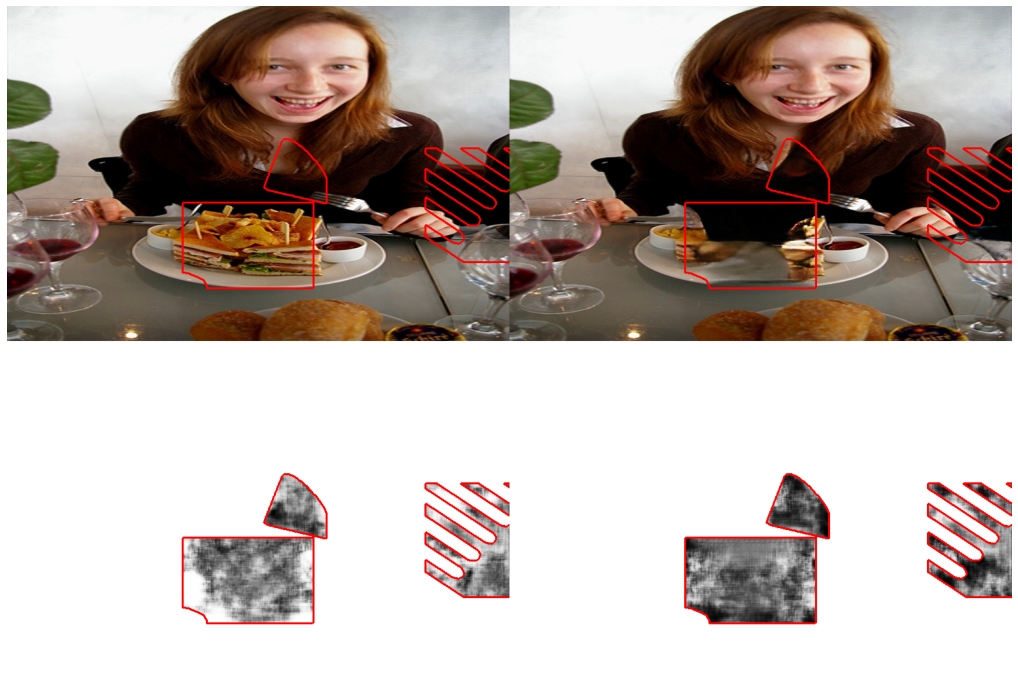

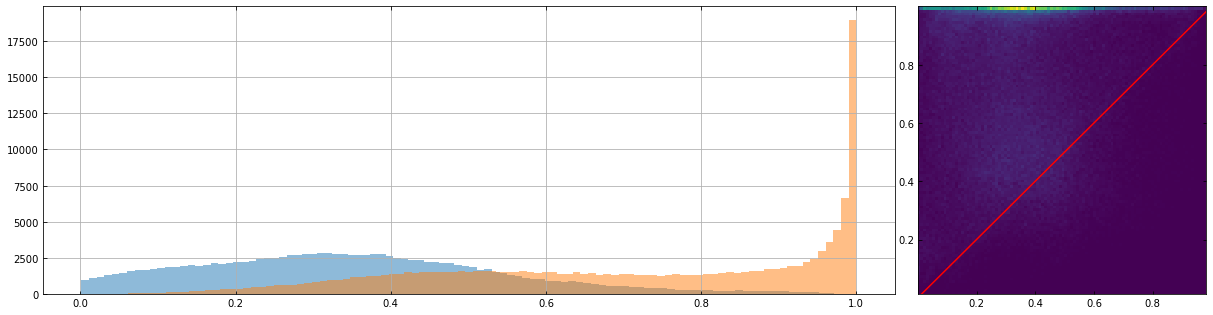

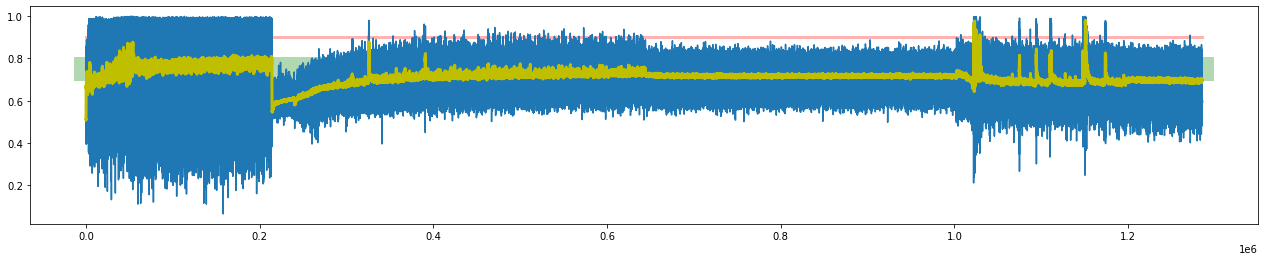

dlr/glr = 2.142591
time 3250s.


 19%|█▉        | 382/2000 [10:18<43:38,  1.62s/it]

Ошибка извлечения данных


 32%|███▏      | 641/2000 [17:16<36:38,  1.62s/it]

Ошибка извлечения данных


 46%|████▌     | 922/2000 [24:50<29:12,  1.63s/it]

Ошибка извлечения данных


 52%|█████▏    | 1035/2000 [27:51<26:01,  1.62s/it]

In [ ]:
batch_size = 2

imagesgen, masksgen = data_generators(batch_size)
last_time = time()

while True:
    for sub_step in tqdm(range(update_step)):
        step = len(accs)

        # Извлечение данных
        try:
            images = next(imagesgen)
            masks, lossweights  = next(masksgen)
            
            samples_in_batch = len(images)
            if samples_in_batch < len(masks):
                masks       =       masks[:samples_in_batch, ...]
                lossweights = lossweights[:samples_in_batch, ...]
        except:
            print('Ошибка извлечения данных')
            continue

        # Прогон
        generated_images, fake_output, real_output = train_step(images, masks, lossweights)

        # Подсчёт доли верных ответов дискриминатора
        fake_output = fake_output.numpy()
        real_output = real_output.numpy()
        submask = masks < 0.5 # Бинарная маска дыр
        TP = np.sum(real_output[submask] > 0.5) # True positive
        TN = np.sum(fake_output[submask] < 0.5) # True negative
        acc = (TP + TN) / 2 / np.sum(submask)   # Accurate
        accs.append(acc)
        
        # Фильтрация последовательности долей верных ответов
        last_argsigm_acc = last_argsigm_acc * exp_filt_k + argsigm(acc) * (1 - exp_filt_k)
        filt_accs.append(sigm(last_argsigm_acc))
        
        # Рассчёт и применение новых скоростей обучения
        glr, dlr = cals_lrs(filt_accs[-1])
        tf.keras.backend.set_value(    generator_optimizer.lr, glr)
        tf.keras.backend.set_value(discriminator_optimizer.lr, dlr)
    
    #if step % update_step == 1:
    generated_images = generated_images.numpy()
    
    show_images(images, masks, generated_images, fake_output, real_output, step // update_step)
    if glr==0:
        print('dlr/glr = inf')
    else:
        print('dlr/glr = %f' % (dlr/glr))
    print('time %ds.' % (time() - last_time))
    
    last_time = time()
    
    # Сохранения
    generator    .save_weights(drive_path(    'generator.tf'))
    discriminator.save_weights(drive_path('discriminator.tf'))
    np.savez('accs', accs=accs)

In [ ]:
generator    .save_weights(drive_path(    'generator.tf'))
discriminator.save_weights(drive_path('discriminator.tf'))